In [0]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
df = pd.read_csv('gs_data.csv')
df = df.iloc[:,1:22]

In [0]:
df.dropna(subset = ['menus.description'], inplace = True)
df = df.sort_values(by=['province'])
df['postalCode'] = df['postalCode'].fillna(method= 'ffill')
df = df.sort_values(by=['postalCode'])
df['latitude'] = df['latitude'].fillna(method='ffill')
df['longitude'] = df['longitude'].fillna(method='ffill')
df['priceRangeMin'] = df['priceRangeMin'].fillna(df['priceRangeMin'].mode()[0])
df['priceRangeMax'] = df['priceRangeMax'].fillna(df['priceRangeMax'].mode()[0])

Pick out day, month and year separately from datetime

In [0]:
df['menus.dateSeen'] = df['menus.dateSeen'].str[:10]
df['menus.dateSeen'] = pd.to_datetime(df['menus.dateSeen'])
df['dateAdded'] = pd.to_datetime(df['dateAdded'])
df['year_dateAdded'] = df['dateAdded'].dt.year
df['month_dateAdded'] = df['dateAdded'].dt.month
df['day_dateAdded']= df['dateAdded'].dt.day
df['year_last_seen'] = df['menus.dateSeen'].dt.year
df['month_last_seen'] = df['menus.dateSeen'].dt.month
df['day_last_seen'] = df['menus.dateSeen'].dt.day


In [0]:
ingred = ['cheese','beef','onion','rice','sauce','salsa','chicken','beans','lettuce','corn','avocado','cilantro']
for i in ingred:
  df[i] = df['menus.description'].str.contains(i,na = False).astype(int)
df['categories'] = df['categories'].astype(str).str.lower()

Remove stopwords from categories

In [34]:
import nltk
nltk.download('stopwords')
#nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('english')
df['categories'] = df['categories'].str.replace('[^\w\s]','')
df['categories_no_stop'] = df['categories'].apply(lambda x:' '.join([word for word in x.split() if word not in (stopwords)]))
df['cuisines'] = df['cuisines'].astype(str).str.lower().str.replace('[^\w\s]','')
df['cuisines_no_stop'] = df['cuisines'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Count the most frequent words and create columns for it.

In [0]:
from collections import Counter
res_type_select = Counter(" ".join(df["categories_no_stop"]).split()).most_common(20)
for i,j in res_type_select:
  df[i] = df['categories'].str.contains(i,na = False).astype(int)
cuisines_type = Counter(" ".join(df["cuisines_no_stop"]).split()).most_common(20)
for i,j in cuisines_type:
  df[i + '_' + 'cuisine'] = df['cuisines'].str.contains(i, na = False).astype(int)


drop irrelevant columns



In [0]:
df = df.drop(['categories','dateUpdated','menuPageURL','menus.category','websites','cuisines','menus.description','categories_no_stop','cuisines_no_stop','dateAdded', 'menus.dateSeen'],axis=1)


create a training data set and create two subsets of data with numeric and categoric type.

In [37]:
df_train = df.copy()

df_test = df[(df['menus.amountMax'].isnull())]
df_test.dropna(subset = ['menus.amountMin'], inplace = True)
df_test_categor = df_test.select_dtypes(exclude=['int', 'float']).astype('category').apply(lambda x: x.cat.codes)
df_test_numeric = df_test.select_dtypes(include=['int','float'])

df_train.dropna(subset = ['menus.amountMax', 'menus.amountMin'], inplace = True)
df_numeric = df_train.select_dtypes(include = ['int', 'float'])
df_categor = df_train.select_dtypes(exclude = ['int', 'float']).astype('category').apply(lambda x: x.cat.codes)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Merge both subsets

In [0]:
df_train_new = pd.concat([df_numeric, df_categor],axis = 1)
df_test_new=pd.concat([df_test_numeric, df_test_categor], axis=1)

In [0]:
from sklearn.ensemble import forest
def set_rf_samples(n):
  #give each tree a random sample of n rows
  forest._generate_sample_indices = (lambda rs, n_samples: forest.check_random_state(rs).randint(0,n_samples,n))

def reset_rf_samples():
  #undo the changes
  forest._generate_sample_indices = (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples, n_samples))

set_rf_samples(25000)


RandomForestRegressor model

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

dep_var = df_train_new['menus.amountMax']
df_train_new = df_train_new.drop(['menus.amountMax', 'menus.amountMin'], axis = 1)
X_train, X_valid, y_train, y_Valid = train_test_split(df_train_new, dep_var, test_size = 0.1)

df_test_new = df_test_new.drop(['menus.amountMin','menus.amountMax'], axis=1)


Fit random forest regressor

In [41]:
m1 = RandomForestRegressor(n_estimators = 500, n_jobs=-1, bootstrap = False, criterion='mse')
m1.fit(X_train, y_train)
from sklearn.metrics import r2_score
r2_score(m1.predict(X_valid), y_Valid)

0.6169938628549392

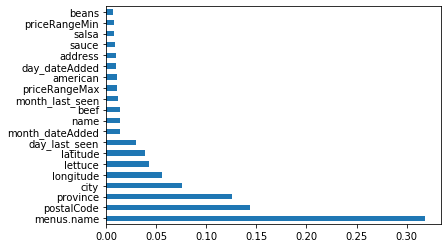

In [42]:
fi = pd.Series(m1.feature_importances_,index = X_train.columns)
fi= fi.sort_values(axis = 0, ascending = False)
to_keep = fi[fi>.01]
df_keep = df_train_new[to_keep.index].copy()
pd.Series(m1.feature_importances_, index = X_train.columns).nlargest(20).plot(kind ='barh')


In [44]:
score_train = m1.score(X_train, y_train)
score_valid = m1.score(X_valid, y_Valid)
print(score_train ,score_valid)

0.9999853522178638 0.5167626595198125


In [45]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(n_estimators = 300, learning_rate = 0.3,booster = 'gbtree', max_depth = 20, min_child_weight = 3, reg_lambda = 0.005, reg_alpha = 10, gamma = 0.25, eta = 0.1)
eval_set = [(X_train, y_train), (X_valid, y_Valid)]
model_xgb.fit(X_train, y_train,eval_set = eval_set, early_stopping_rounds = 30)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:10:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:14.0688	validation_1-rmse:12.6241
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:11.8848	validation_1-rmse:11.2951
[2]	validation_0-rmse:10.1723	validation_1-rmse:10.7974
[3]	validation_0-rmse:9.11647	validation_1-rmse:10.2236
[4]	validation_0-rmse:8.24446	validation_1-rmse:10.0345
[5]	validation_0-rmse:7.66221	validation_1-rmse:10.01
[6]	validation_0-rmse:6.96913	validation_1-rmse:9.66421
[7]	validation_0-rmse:6.23895	validation_1-rmse:9.23823
[8]	validation_0-rmse:5.72542	validation_1-rmse:9.07298
[9]	validation_0-rmse:5.18481	validation_1-rmse:8.69455
[10]	validation_0-rmse:4.62546	validation_1-rmse:8.50385
[11]	validation_0-rmse:4.27325	validation_1-rmse:8.39331
[12]	validation_0-rmse:3.95617	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0.25,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=20, min_child_weight=3, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=10, reg_lambda=0.005, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [46]:
r2_score(y_Valid, model_xgb.predict(X_valid))

0.7448898476613397

In [0]:
data_dmatrix = xgb.DMatrix(data = X_train, label = y_train)
params = {'learning_rate':0.40,'max_depth':20,'min_child_weight':3,'reg_lambda':0.005,'reg_alpha':5,'gamma':0.5,'eta':0.1}
cv_results = xgb.cv(dtrain = data_dmatrix, params = params, nfold = 10, num_boost_round = 2000, early_stopping_rounds = 50, metrics = 'rmse', seed = 123)


In [0]:
cv_results

In [0]:
r2_score(y_Valid, model_xgb.predict(X_valid))

In [0]:
results = model_xgb.evals_result()
fi_xgb = model_xgb.feature_importances_


In [0]:
price = model_xgb.predict(df_test_new)